# SYMULACJE I ANALIZA DANYCH W JĘZYKU PYTON

## TEMAT PROJEKTU: Inwazja Zombie - Zombie vs Ludzkość

![zombies](img/zombie.jpeg)

Symulacja polega na odtworzeniu popularnego scenariusza filmów SF, których fabuła opiera się walce ludzkości z grupą Zombie. 


Początkowo wszyscy bohaterowi s ą ludźmi (poza losowym procentem zarażonych wirusem Zombie – to od nich zaczyna się epidemia ). Każdy człowiek posiada przypisane doświadczenie w skali od 0 do 90% z krokiem 10% które odzwierciedla możliwość zwycięstwa  nad Zombie lub zastania pokonanym i zamienia się w Zombie. 

Ogólnie rzecz biorąc, każde spotkanie jest  traktowane jako probabilistyczne losowanie:

- Człowiek vs Zombie:

    - Człowiek zostaje pokonany                                                                                           

    Nie każdy zagryziony przez zombie zamienia się w zombie. Parametr zombifikacji określa jaki procent pokonanych ludzi zamienia się w zombie. Standardowo 1 czyli wszyscy pokonani ludzie zamieniają się w zombie. 
    
    - Zombie zostaje zabity

    Ludzie, którzy przeżyli spotkanie z zombie zwiększają doświadczenie. Wzrost doświadczenia - człowiek, który pokona zombie może zwiększać swoje doświadczenie. Wzrost doświadczenia  jest losowy, szanse są odwrotnie proporcjonalne do obecnego doświadczenia. Szansa na wzrost doświadczenia przy doświadczeniu 0 to 100%, przy doświadczeniu 90 - 0% 
    
    
    
- Człowiek vs Człowiek oraz  Zombie vs Zombie: Te same grupy sobie nie szkodzą

    
## Wynik symulacji odpowiada na pytanie: Czy ludzkość zdoła odeprzeć atak Zombie ????



## Standardowe parametry modelu (wszystkie można zmienić):


* Wielkość populacji: 100000
* Początkowy  procent zombie w populacji:  2.5%
* Parametr zombifikacji: z_ratio=1
* Rozkład doświadczenia w populacji równomierny : [1,1,1,1,1,1,1,1,1,1]

Inspirowane przez: http://www.econometricsbysimulation.com/2013/04/the-dynamics-of-zombie-apocalypse.html







In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import logging
from IPython.core.display import display, HTML

### Przełączenie poziomu logowania na INFO pozwala prześledzić symulację

In [28]:
logger = logging.getLogger()
assert len(logger.handlers) == 1
handler = logger.handlers[0]
handler.setLevel(logging.WARNING)
# handler.setLevel(logging.INFO)

In [3]:
%matplotlib inline

### Pairup - funkcja pomocnicza do złożenia populacji w losowo wybrane pary

In [4]:
def pairup(x, unmatched=True):
    if type(x) == int:
        x = np.arange(x)
    xleng = x.size
    hleng = np.int(np.floor(xleng / 2))
    np.random.shuffle(x)
    if xleng % 2 and unmatched:
        t = x[-1]
        x = np.delete(x, -1)
        x = x.reshape(hleng, 2)
        x = np.vstack((x, (t, t)))
    else:
        x = x.reshape(hleng, 2)
    return x

### Funkcja symulacji

In [5]:
def sim(population=10000, infected=0.025, exp=(1, 1, 1, 1, 1, 1, 1, 1, 1, 1), z_ratio=1, exp_growth=False):
    # wartości doświadczenia
    types = np.arange(0, 100, 10, dtype=int)

    # względne wielkości poszczególnych grup
    freq = np.array(exp)
    htypes = np.array([types, freq])

    # ilość osób dla poszczególnych kategorii doświadczenia
    perc = np.round(freq / sum(freq) * population).astype(int)

    # cała populacja
    walking = np.repeat(types, perc)

    # ilość zombie
    nselected = np.int(np.round(population * infected))

    # wybór zombie
    zombies = np.random.choice(np.arange(population), nselected, replace=False)
    healthy = np.delete(walking, zombies)
    x = np.repeat(-77, nselected)

    # wstawiamy zombie do populacji
    walking = np.concatenate((healthy, x))

    # procent zombie w populacji
    perc_zombies = np.mean(walking == -77)

    nthings = walking.size
    nthings_vector = np.array([nthings])

    # ilość zombie w czasie
    nzombies = np.array([np.sum(walking == -77)])

    # ilość ludzi dla poszczególnych kategorii
    nhumans = np.array([np.sum(walking != -77)])
    nhumans0 = np.sum(walking == 0)
    nhumans10 = np.sum(walking == 10)
    nhumans20 = np.sum(walking == 20)
    nhumans30 = np.sum(walking == 30)
    nhumans40 = np.sum(walking == 40)
    nhumans50 = np.sum(walking == 50)
    nhumans60 = np.sum(walking == 60)
    nhumans70 = np.sum(walking == 70)
    nhumans80 = np.sum(walking == 80)
    nhumans90 = np.sum(walking == 90)
    
    logging.info("Rozkład populacji:  %d %d %d %d %d %d %d %d %d %d" % (nhumans0, nhumans10, nhumans20,
                                                                    nhumans30, nhumans40, nhumans50,
                                                                    nhumans60, nhumans70, nhumans80,
                                                                    nhumans90))

    max_rounds = 50
    i = 0
    # powtarzamy symulacje do max_rounds chyba że wcześniej nie zostanie żaden żywy człowiek albo zombie
    while (nzombies[i] and nhumans[i] and i < max_rounds):
        i += 1

        # tworzymy losowe pary (numery osób)
        encounter = pairup(nthings)

        # pary (doświadczenie, -77 dla zombie)
        types = np.vstack((walking[encounter[:, 0]], walking[encounter[:, 1]])).T

        # rezultaty spotkań
        conflict = np.zeros(types.shape, dtype=int)

        # jeśli mamy parę człowiek - zombie to ją odwracamy
        hvz = (types[:, 1] == -77) & (types[:, 0] >= 0)
        temp = np.copy(types)
        types[hvz, 0] = temp[hvz, 1]
        types[hvz, 1] = temp[hvz, 0]

        # zamieniamy te same pary w tablicy encounter
        temp = np.copy(encounter)
        encounter[hvz, 0] = temp[hvz, 1]
        encounter[hvz, 1] = temp[hvz, 0]

        # znajdujemy pary zombie - człowiek
        zvh = (types[:, 0] == -77) & (types[:, 1] >= 0)

        # prawdopodobieństwo wygranej zombie
        win = (np.random.uniform(size=sum(zvh)) > types[zvh, 1] / 100)

        # zombie wygrywa - kod 4 lub ginie - kod 2
        conflict[zvh, 0] = np.where(win, 4, 2)

        # człowiek wygrywa - kod 6 lub ginie - kod 1
        conflict[zvh, 1] = np.where(win, 1, 6)

        # zombies nie szkodzą sobie - kod 3
        conflict[types[:, 0] == types[:, 1],] = 3

        # ludzie nie szkodzą sobie - kod 3
        conflict[(types[:, 0] >= 0) & (types[:, 1] >= 0),] = 3

        # ludzie, którzy zginęli zamieniają się w zombie - kod 1, albo giną - kod 5
        fallen = np.sum(conflict == 1)
        zombification = (np.random.uniform(size=fallen) < z_ratio)
        conflict[conflict == 1] = np.where(zombification, 1, 5)
        walking[encounter[conflict == 1]] = -77
        logging.info(
            "Pokonanych ludzi %s, zamiana w zombie %s, umiera %s" % (
            fallen, np.sum(zombification), np.sum(conflict == 5)))
        logging.info("Gine %s zombie" % np.sum(conflict == 2))

        # ludzie, którzy przeżyli spotkanie z zombie zwiększają doświadczenie 
        if exp_growth:
            winners = encounter[conflict == 6]
            logging.debug("ludzie którzy pokonali zombie %s, doświadczenie %s" % (winners, walking[winners]))
            exp_gain = (np.random.uniform(size=len(winners)) > walking[winners] / 100)
            logging.info("Ilość osób zwiększających doświadczenie %d" % np.sum(walking[winners[exp_gain]] < 90))
            walking[winners[exp_gain]] = np.minimum(90, walking[winners[exp_gain]] + 10)
            logging.debug("ludzie którzy pokonali zombie %s, doświadczenie %s" % (winners, walking[winners]))

        # pokonane zombie oraz nieżywych i niezamienionych w zombie usuwamy
        walking = np.delete(walking, [encounter[(conflict == 5) | (conflict == 2)]])

        # walking = np.delete(walking, [encounter[conflict == 2]])

        # procent zombie
        perc_zombies = np.append(perc_zombies, np.mean(walking == -77))

        # całkowita populacja (ludzie i zombie)
        nthings = len(walking)
        nthings_vector = np.append(nthings_vector, nthings)

        # ilość zombie
        nzombies = np.append(nzombies, sum(walking == -77))

        # ilość ludzi
        nhumans = np.append(nhumans, sum(walking != -77))

        # ilość ludzi dla poszczególnych wielkości doświadczenia
        nhumans0 = np.append(nhumans0, sum(walking == 0))
        nhumans10 = np.append(nhumans10, sum(walking == 10))
        nhumans20 = np.append(nhumans20, sum(walking == 20))
        nhumans30 = np.append(nhumans30, sum(walking == 30))
        nhumans40 = np.append(nhumans40, sum(walking == 40))
        nhumans50 = np.append(nhumans50, sum(walking == 50))
        nhumans60 = np.append(nhumans60, sum(walking == 60))
        nhumans70 = np.append(nhumans70, sum(walking == 70))
        nhumans80 = np.append(nhumans80, sum(walking == 80))
        nhumans90 = np.append(nhumans90, sum(walking == 90))

        logging.info("LUDZIE: %s ZOMBIE %s" % (nhumans[-1], nzombies[-1]))
        logging.info("Rozkład populacji:  %d %d %d %d %d %d %d %d %d %d" % (nhumans0[-1], nhumans10[-1], nhumans20[-1],
                                                                            nhumans30[-1], nhumans40[-1], nhumans50[-1],
                                                                            nhumans60[-1], nhumans70[-1], nhumans80[-1],
                                                                            nhumans90[-1]))

    result = {'humans': nhumans, 'zombies': nzombies, 'humans0': nhumans0, 'humans10': nhumans10, 'humans20': nhumans20,
              'humans30': nhumans30,
              'humans40': nhumans40, 'humans50': nhumans50, 'humans60': nhumans60, 'humans70': nhumans70,
              'humans80': nhumans80, 'humans90': nhumans90}
    return result

### Statystyki

In [34]:
def statistics(dict):
    df=pd.DataFrame.from_dict(dict)
    humans_p = ['humans'+str(i) for i in range(0,100,10)]
    survivors_beg = df.iloc[0][humans_p]
    zombies_beg = df.iloc[0]['zombies']
    survivors = df.iloc[-1][humans_p]
    zombies = df.iloc[-1]['zombies']
    surv_list_beg = [i for i in survivors_beg]
    surv_list = [i for i in survivors]
    display(HTML("<b>Początek symulacji</b>"))
    print('Populacja zombi %d' %zombies_beg)
    print('Populacja ludzi %d' %survivors_beg.sum())
    print("Rozkład populacji:  %s" % surv_list_beg)
    display(HTML("<b>Koniec symulacji</b>"))
    print('Populacja zombi %d' %zombies)
    print('Populacja ludzi %d' %survivors.sum())
    print("Rozkład populacji:  %s" % surv_list)

### Funkcje rysujące wykresy

In [7]:
def plot_simulation(dict):
    df=pd.DataFrame.from_dict(dict)
    humans_p = ['humans'+str(i) for i in range(0,100,10)]
    plt.plot(df['zombies'],label='Z')
    plt.plot(df[humans_p])
    plt.text(len(df), df['zombies'][len(df)-1], "Zombies")

In [11]:
def plot_population(dict):   
    df=pd.DataFrame.from_dict(dict)
    humans_p = ['humans'+str(i) for i in range(0,100,10)]
    beg=df[humans_p][:1]
    end=df[humans_p][-1:]
    tgth=pd.concat((beg,end)).transpose()
    tgth.columns=[['period','period'],['beginning','end']]
    plt.bar(range(0,100,10),tgth['period']['beginning'],3,label='początek')
    plt.bar(range(3,103,10),tgth['period']['end'],3,label='koniec',color='red')
    plt.xlabel('Doświadczenie')
    plt.ylabel('Populacja')
    plt.xticks(range(3,103,10), range(0,100,10),rotation='vertical')
    plt.legend()
    plt.tight_layout()

# Symulacja 1
## Jeśli osób z doświadczeniem jest mało, zombie opanowują świat :(

Symulacja dla dystrybucji, gdzie doświadczenie w populacji zmniejsza się liniowo od 5 do 0.5.

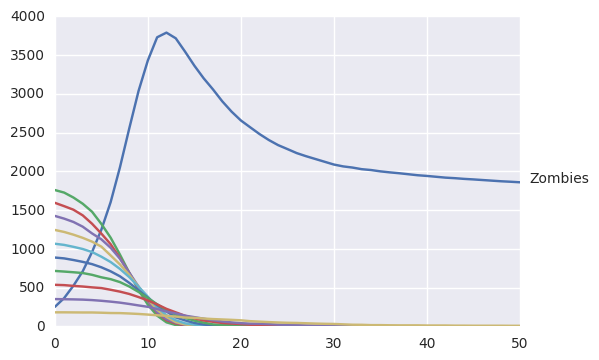

In [27]:
d1=sim(exp=[5, 4.5, 4, 3.5, 3, 2.5, 2, 1.5, 1, 0.5])
plot_simulation(d1)

### Tutaj (prawie) nikt nie przeżył

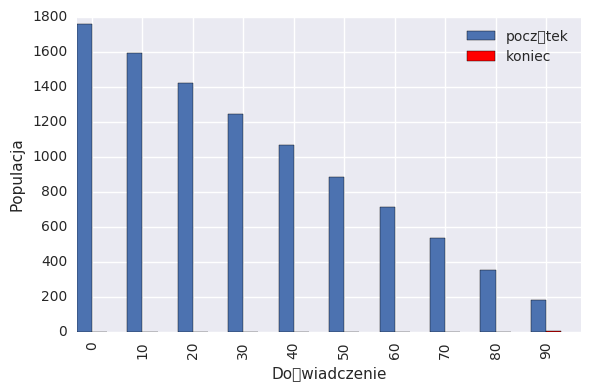

In [43]:
plot_population(d1)

In [35]:
statistics(d1)

Populacja zombi 250
Populacja ludzi 9750
Rozkład populacji:  [1758, 1593, 1424, 1243, 1065, 887, 714, 535, 351, 180]


Populacja zombi 1858
Populacja ludzi 7
Rozkład populacji:  [0, 0, 0, 0, 0, 0, 0, 0, 1, 6]


# Symulacja 2

## Jeśli mamy populację o równomiernie rozłożonym doświadczeniu, zombie nie mają szans :) Ale osób, które mają małe doświadczenie przeżywa mało :(

Symulacja dystrybucji, gdzie doświadczenie w populacji jest rozłożone równomiernie. 

INFO:Rozkład populacji:  969 973 978 970 984 971 972 973 977 983
INFO:Pokonanych ludzi 122, zamiana w zombie 122, umiera 0
INFO:Gine 122 zombie
INFO:LUDZIE: 9628 ZOMBIE 250
INFO:Rozkład populacji:  943 957 963 956 976 958 956 965 971 983
INFO:Pokonanych ludzi 139, zamiana w zombie 139, umiera 0
INFO:Gine 107 zombie
INFO:LUDZIE: 9489 ZOMBIE 282
INFO:Rozkład populacji:  922 937 939 937 964 947 946 960 961 976
INFO:Pokonanych ludzi 148, zamiana w zombie 148, umiera 0
INFO:Gine 128 zombie
INFO:LUDZIE: 9341 ZOMBIE 302
INFO:Rozkład populacji:  903 910 917 913 943 935 935 949 961 975
INFO:Pokonanych ludzi 166, zamiana w zombie 166, umiera 0
INFO:Gine 128 zombie
INFO:LUDZIE: 9175 ZOMBIE 340
INFO:Rozkład populacji:  879 888 898 889 919 922 918 934 955 973
INFO:Pokonanych ludzi 170, zamiana w zombie 170, umiera 0
INFO:Gine 148 zombie
INFO:LUDZIE: 9005 ZOMBIE 362
INFO:Rozkład populacji:  848 858 875 865 904 906 907 923 949 970
INFO:Pokonanych ludzi 196, zamiana w zombie 196, umiera 0
INFO:Gine 15

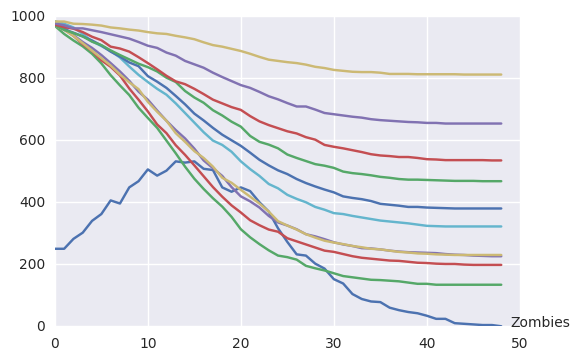

In [14]:
d2=sim()
plot_simulation(d2)

### Osoby z zerowym doświadczeniem giną prawie wszystkie, 80% osób z największym doświadczeniem przeżywa

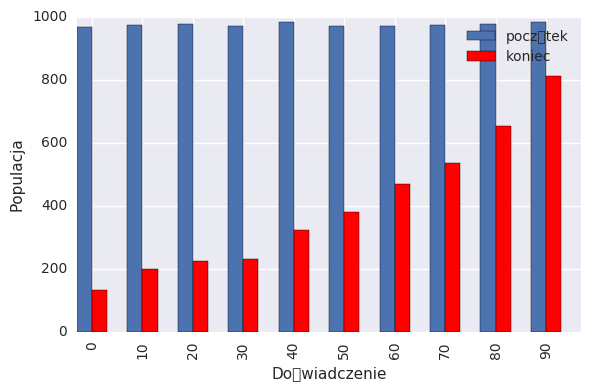

In [44]:
plot_population(d2)

In [36]:
statistics(d2)

Populacja zombi 250
Populacja ludzi 9750
Rozkład populacji:  [969, 973, 978, 970, 984, 971, 972, 973, 977, 983]


Populacja zombi 0
Populacja ludzi 3959
Rozkład populacji:  [134, 198, 226, 230, 322, 380, 468, 535, 654, 812]


# Symulacja 3
Dystrybucja równomierna od 5 do 1. Tutaj ludzie i zombie praktycznie wybijają się nawzajem.

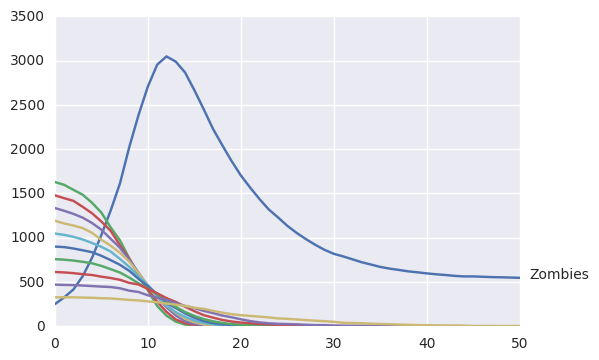

In [37]:
d3=sim(exp=[5.000000, 4.555556, 4.111111, 3.666667, 3.222222, 2.777778, 2.333333, 1.888889, 1.444444, 1])
plot_simulation(d3)

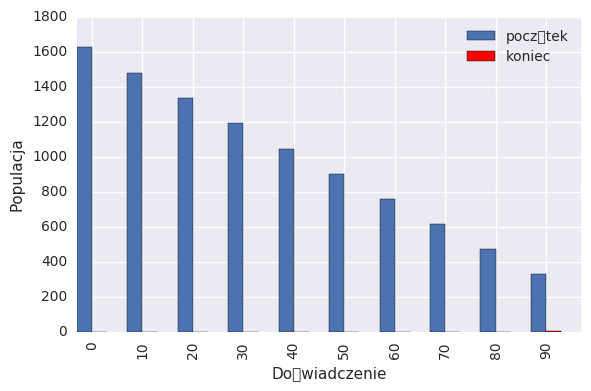

In [45]:
plot_population(d3)

In [38]:
statistics(d3)

Populacja zombi 250
Populacja ludzi 9750
Rozkład populacji:  [1629, 1479, 1335, 1192, 1047, 900, 758, 613, 470, 327]


Populacja zombi 547
Populacja ludzi 3
Rozkład populacji:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 3]


# Symulacja 4
Jeśli założymy, że ludzie zdobywają doświadczenie, to ludzkość ma szanse. Rozkład populacji taki sam jak dla symulacji 1, ale włączony proces zwiększania doświadczenia.

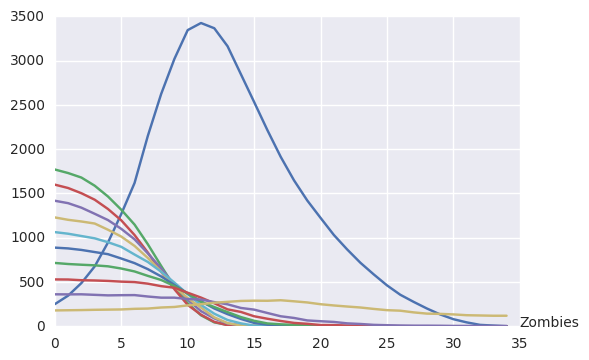

In [39]:
d4=sim(exp=[5, 4.5, 4, 3.5, 3, 2.5, 2, 1.5, 1, 0.5], exp_growth=True)
plot_simulation(d4)

In [40]:
statistics(d4)

Populacja zombi 250
Populacja ludzi 9750
Rozkład populacji:  [1770, 1599, 1417, 1229, 1063, 888, 715, 529, 361, 179]


Populacja zombi 0
Populacja ludzi 123
Rozkład populacji:  [0, 0, 0, 0, 0, 0, 0, 0, 4, 119]


# Symulacja 5

Tak jak w symulacji 4, ale zakładamy, że co drugi człowiek zamienia się w zombie - reszta spokojnie ginie :)

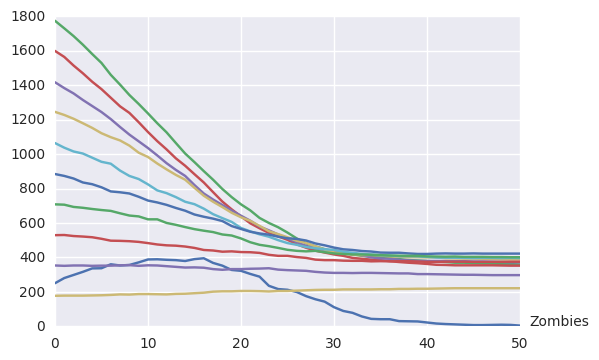

In [41]:
d5=sim(exp=[5, 4.5, 4, 3.5, 3, 2.5, 2, 1.5, 1, 0.5], exp_growth=True, z_ratio = 0.5)
plot_simulation(d5)

In [42]:
statistics(d5)

Populacja zombi 250
Populacja ludzi 9750
Rozkład populacji:  [1774, 1599, 1417, 1245, 1064, 884, 708, 529, 353, 177]


Populacja zombi 4
Populacja ludzi 3583
Rozkład populacji:  [359, 352, 372, 388, 396, 422, 401, 375, 297, 221]
